# Brain Tumor Detection
    Team Phoenix
    Name: Meghanshu Bhatt (NUID: 002961585)
    Name: Manav Malavia (NUID: 002763769)
    Name: Divya Dubey (NUID: 002776608)
    


#### Rubric 

Project submission details.
Please submit:
1. code inside of a Jupyter notebook, that goes all the way from reading in the data to
printing out model performance visualizations. Please make sure to submit commented
code.
2. a short write-up explaining the goals, and importance of the project and,
3. Slide deck with not more than 6-7 slides summarizing the project, packages used,
goal, etc.
The goal of the project is making sure you tried your very best in building a state-of-the-art
predictive model while adhering to acceptable, good data science practices. A minimum of two
different ML algorithms needs to be evaluated. Hyperparameter tuning differences DO NOT
count as separate models. Data or feature Engineering also does not count as a separate
algorithm. Please make sure you provide a detailed model comparison visual as well in your
Jupyter notebook.

Point breakdown
Selection of performance metric of the algorithm, giving detailed reason = 5 points
Each algorithm with hyper-parameter tuning = 10 points each (10 times 3 = 30 total)
At least one comprehensive results visualization = 10 points, with 2 points for the legends, 2
points for clear labelling, 5 points for the right choice of data plot. We trust your creativity:
Data visualization WILL NOT be explicitly covered in this course, and you will need to come up
with your own ones.

A final short write-up (problem statement, importance, and solution, all in a paragraph or two)
and slides (the same section but with nice visuals) will carry 5 points
Code poorly commented will lose 5 marks. Comments are not a big stretch, is it? Just put them
in. This is to help yourself and the TA and me who will have to evaluate the cool projects.
Please submit code that runs from top to bottom of the Jupyter notebook when we click Run
all. If the code fails and throws up an error, it will incur a penalty of 5 points (sorry).
Please submit on time because late submissions without previous explanation to me will accrue
5-point penalty for each day. The penalty is there to ensure fairness to everyone.
Good luck :-), we are here to help you do your best!




### What is Brain Tumor ?

    A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.

</br>
<br>
</br>
<center>
<img src="https://www.uib.no/sites/w3.uib.no/files/styles/content_main_wide_1x/public/media/mri_primary.jpg?itok=4f4Cl3OP&timestamp=1579194807"/>
</center>

</br>

### About Dataset

The image data that was used for this problem is Brain MRI Images for Brain Tumor Detection. It conists of MRI scans of two classes:

    NO - no tumor, encoded as 0
    YES - tumor, encoded as 1
Unfortunately, the data set description doesn't hold any information where this MRI scans come from and so on.

### Approach

We will use 3 models on this notebook, which are Deep Neural Networks, Convolution Neural Networks (CNNs) and VGG19. So the contents of the notebook will be as follows,

1. Importing libraries
2. Loading Images and creating utility function for data augmentation
3. Image demostration
4. CNN models
5. ResNet50V2:
    - Training without data augmentation
    - Further tune the model with data augmentation
6. VGG19:
    - Training without data augmentation
    - Further tune the model with data augmentation
7. InceptionV3:
    - Training without data augmentation
    - Further tune the model with data augmentation
8. Result
   
Let's get started!

### Importing libraries

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import torchvision
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
from sklearn.utils import shuffle
from PIL import Image
import os
from sklearn.model_selection import KFold
from torchsummary import summary
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Loading Data and Augmentation

The images in this dataset are MRI scans of brains and are therefore very different to the images in the used in the pretrained classification models from PyTorch, which use the IMAGENET dataset. For this reason I want to calculate the mean and standard deviation of the MRI scan dataset so that it can be normalised properly.

In [3]:
ROOT_PATH = r"./brain_tumor_dataset/"

##### Loading Images and creating utility function for data augmentation

A lot of effort in solving any machine learning problem goes into preparing the data. PyTorch provides many tools to make data loading easy and hopefully, to make your code more readable.

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

    __len__ so that len(dataset) returns the size of the dataset.
    __getitem__ to support the indexing such that dataset[i] can be used to get ith sample.

Below Cell Explanation

    __init__: In this section, we have created a dataframe, where First column will be having the image path and second column containing labels, along with that shuffled the dataset.

    __len__: In this section, return the sum of files present in both folder
    __getitem__: In this Section, as idx can be single integer or slicing, therefore need to return the images in grayscale (as many of the images are in grayscale and some of them are in RGB Channel, so converted into one), and return the Torch tensor array with labels

In [4]:
from glob import glob
# make custome mri dataset loader
class MRI_Dataset(Dataset):
    '''MRI Dataset Loader
    Args:
        file_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied on a sample.
        no_class (list): list of all the images in the no class
        yes_class (list): list of all the images in the yes class
        file_list (list): list of all the images in the dataset
        label_list (list): list of all the labels in the dataset
        dataframe (dataframe): dataframe of the dataset
        '''

    def __init__(self, file_dir, transform):
        self.file_dir = file_dir
        self.transform = transform
        self.no_class = glob(self.file_dir+'/no/*')
        self.yes_class = glob(self.file_dir+'/yes/*')
        self.file_list = self.no_class + self.yes_class
        self.label_list = [0]*len(self.no_class) + [1]*len(self.yes_class)
        self.dataframe = pd.DataFrame({'image': self.file_list,
                                     'label': self.label_list})  
        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    # return the length of the dataset
    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    # return the image and the label of the image, given the index
    def __getitem__(self, index):
        img_path = self.dataframe['image'][index]
        labels = self.dataframe['label'][index]
        labels = labels.tolist()

        if type(img_path) == str:
            img_path = [img_path]

        img_array = []
        for image in img_path:
            img = Image.open(image).convert("RGB")
            img_transformed = self.transform(img)
            array = np.asarray(img_transformed)
            img_array.append(array)

        img_array = np.stack(img_array)  # Stack the images along a new axis
        return [torch.tensor(img_array, device=device).squeeze(0), torch.tensor(labels, device=device)]
    
    # print the dataset
    def __repr__(self):
        print("Data loading succeed!!")
        print("-"*80)
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(plt.imread(self.dataframe.image[i]))
            plt.title(os.path.split(os.path.split(self.dataframe.image[i])[0])[-1])
            plt.axis("off")

        rep = pd.DataFrame({'File Path' : self.file_list})
        return str(rep.head(9))

For data augmentation, i use

- ColorJitter : randomly change the brightness
- RandomHorizontalFlip : randomly flip the image horizontally
- Resize : for model convenient resize the image pixel to (128,128)
- ToTensor : for pytorch model, make nparray to Torch Tensor

In [5]:
data_transform = transforms.Compose([
                                     transforms.ColorJitter(brightness=0),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.Resize((128,128)),
                                     transforms.ToTensor(),
                                     ])
                                     

Data loading succeed!!
--------------------------------------------------------------------------------


                             File Path
0  ./brain_tumor_dataset//no/30 no.jpg
1  ./brain_tumor_dataset//no/22 no.jpg
2  ./brain_tumor_dataset//no/41 no.jpg
3  ./brain_tumor_dataset//no/14 no.jpg
4  ./brain_tumor_dataset//no/no 10.jpg
5  ./brain_tumor_dataset//no/18 no.jpg
6   ./brain_tumor_dataset//no/no 9.png
7  ./brain_tumor_dataset//no/no 7.jpeg
8   ./brain_tumor_dataset//no/no 8.jpg

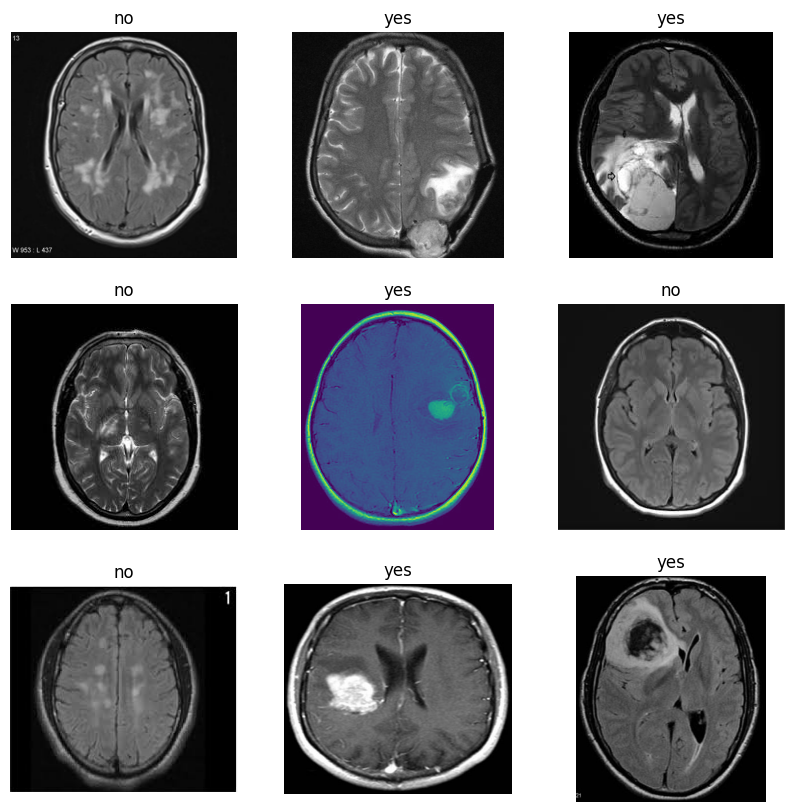

In [6]:
dataset = MRI_Dataset(ROOT_PATH, transform = data_transform)
dataset

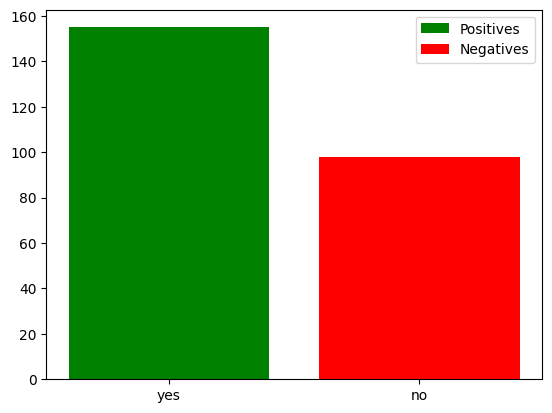

In [7]:
# Distribution of the data
yes_len = len(os.listdir(f"./brain_tumor_dataset/yes/"))
no_len = len(os.listdir(f"./brain_tumor_dataset/no/"))
plt.bar("yes", yes_len, color='g', label="Positives")
plt.bar("no", no_len, color='r', label="Negatives")
plt.legend()
plt.show()

In [8]:
train, test = random_split(dataset, [200, 53],generator=torch.Generator().manual_seed(42))
print("Total number of dataset:",len(dataset))
print("Train dataset:",len(train))
print("Test dataset:",len(test)) 

Total number of dataset: 253
Train dataset: 200
Test dataset: 53


## Confusion Matrix

The classification report you provided shows various performance metrics for each class in the binary classification problem. 
Here's a brief explanation of each metric:

-   Precision: This is the number of true positive predictions divided by the total number of positive predictions (true positives + false positives). A high precision indicates that when the model predicts a positive class (1), it is correct most of the time.


-   Recall: This is the number of true positive predictions divided by the total number of actual positives (true positives + false negatives). A high recall indicates that the model is good at identifying positive instances.


-   F1-score: This is the harmonic mean of precision and recall. It balances both precision and recall, providing a single value that represents the model's performance. A high F1-score indicates a good balance between precision and recall.



The report also provides overall accuracy, macro average, and weighted average metrics:

-   Accuracy: This is the total number of correct predictions divided by the total number of instances. 

-   Macro average: This is the average of the metrics for each class, without considering the class distribution. For precision, recall, and F1-score.
-   Weighted average: This is the average of the metrics for each class, weighted by the number of instances in each class. For precision, recall, and F1-score.
  


In [9]:
all_model = {}

### SVM Classifier

Support Vector Machine (SVM) is a powerful and versatile supervised machine learning algorithm used for classification and regression tasks. The main idea behind SVM is to find the best hyperplane (or decision boundary) that separates the data points of different classes with the maximum margin possible. Here's a high-level overview of how SVM works:

1.  Mapping data to a higher-dimensional space: If the data points are not linearly separable in their original space, SVM can use a technique called the "kernel trick" to map the data points to a higher-dimensional space where they may become linearly separable. Commonly used kernel functions include linear, polynomial, radial basis function (RBF), and sigmoid.

2.  Finding the optimal hyperplane: SVM seeks to find the optimal hyperplane that maximizes the margin between the two classes. The margin is the distance between the hyperplane and the closest data points from each class, which are called support vectors. The support vectors are the critical elements of the training dataset, as they determine the position and orientation of the hyperplane.

3.  Regularization: SVM has a regularization parameter, often denoted as "C," which controls the trade-off between maximizing the margin and minimizing the classification error. A smaller value of C creates a wider margin, which may allow some misclassifications, while a larger value of C creates a narrower margin that tries to classify all the training examples correctly, even at the cost of a smaller margin.

4.  Classification: Once the optimal hyperplane is found, it can be used to classify new, unseen data points. For a linear SVM, the decision function is a simple dot product between the feature vector of the new data point and the weights vector, plus a bias term. If the result is positive, the data point belongs to one class; if it's negative, it belongs to the other class. For non-linear SVMs, the kernel function is applied to the new data point before calculating the dot product.

In summary, SVM works by mapping the data to a higher-dimensional space, finding the optimal hyperplane that maximizes the margin between classes, and then using this hyperplane to classify new data points. The algorithm can handle both linear and non-linear classification tasks, making it a versatile tool for a wide range of applications.




</br>
<br>
</br>
<center>
<img src="https://vitalflux.com/wp-content/uploads/2022/08/support-vector-machine-1.png"/>
</center>

</br>

In [10]:
import random

class BrainTumorSVM:
    '''Brain Tumor SVM Classifier
    Args:
        train_set (Dataset): Training dataset
        test_set (Dataset): Testing dataset
        X_train (numpy array): Training data
        y_train (numpy array): Training labels
        X_test (numpy array): Testing data
        y_test (numpy array): Testing labels
        '''

    def __init__(self, train_set, test_set):
        self.train_set = train_set
        self.test_set = test_set
        self.X_train, self.y_train = self.extract_data(train_set)
        self.X_test, self.y_test = self.extract_data(test_set)

    # extract the data and labels from the dataset
    def extract_data(self, dataset):
        X = []
        y = []
        for data in dataset:
            X.append(data[0].numpy().flatten())
            y.append(data[1].item())
        return np.array(X), np.array(y)

    # train the SVM model, and return the best model with the best parameters using grid search
    def grid_search(self, param_grid):
        svc = svm.SVC(probability = True, random_state = 42)
        grid = GridSearchCV(svc, param_grid, verbose=2)
        grid.fit(self.X_train, self.y_train)
        print("Best parameters found: ", grid.best_params_)
        return grid.best_estimator_

    # evaluate the model, and plot the confusion matrix
    def evaluate_model(self, model):
        y_pred = model.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_pred)
        print("Confusion Matrix: \n", cm)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)
        print("Accuracy: ", accuracy)

        # Plot confusion matrix
        plot_confusion_matrix(model, self.X_test, self.y_test, display_labels=["No", "Yes"], cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()
        return accuracy
    
    # Helper function to plot sample images for each case in confusion matrix
    def plot_confusion_matrix_samples(self, model, num_samples=5):
        y_pred = model.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_pred)

        # Find indices for each case in confusion matrix
        indices = {
            'tp': np.where((self.y_test == 1) & (y_pred == 1))[0],
            'tn': np.where((self.y_test == 0) & (y_pred == 0))[0],
            'fp': np.where((self.y_test == 0) & (y_pred == 1))[0],
            'fn': np.where((self.y_test == 1) & (y_pred == 0))[0]
        }

        for case in indices:
            np.random.shuffle(indices[case])

        # Plot sample images for each case
        for case in indices:
            print(f"{case.upper()} Samples:")
            sample_indices = indices[case][:num_samples]
            self.plot_sample_images(sample_indices, case)
            print()

    def plot_sample_images(self, indices, title):
        fig, axes = plt.subplots(1, len(indices), figsize=(3 * len(indices), 3))
        for i, idx in enumerate(indices):
            img = self.test_set[idx][0].permute(1, 2, 0).numpy()
            img = (img * 255).astype(np.uint8)
            if len(indices) == 1:
                axes.imshow(img)
                axes.set_title(f"{title.upper()} {i + 1}")
                axes.axis("off")
            else:
                axes[i].imshow(img)
                axes[i].set_title(f"{title.upper()} {i + 1}")
                axes[i].axis("off")
        plt.show()



In [11]:
# Initialize BrainTumorSVM with train and test sets
brain_tumor_svm = BrainTumorSVM(train, test)

In [12]:
# Perform grid search
param_grid = {'C':[0.1,1,10,100],
              'gamma':[0.0001,0.001,0.1,1],
              'kernel':['rbf','poly']}

In [13]:

best_model = brain_tumor_svm.grid_search(param_grid)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   3.5s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   3.0s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   2.9s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   2.9s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   3.0s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   2.8s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   2.7s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   2.7s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   2.8s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   2.7s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   3.6s
[CV] END .....................C=0.1, gamma=0.00

Confusion Matrix: 
 [[11 12]
 [ 2 28]]
Accuracy:  0.7358490566037735


/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


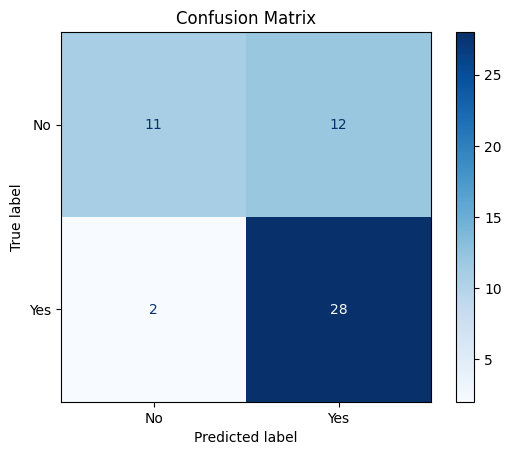

In [14]:
# Evaluate model
svm_acc = brain_tumor_svm.evaluate_model(best_model)


TP Samples:


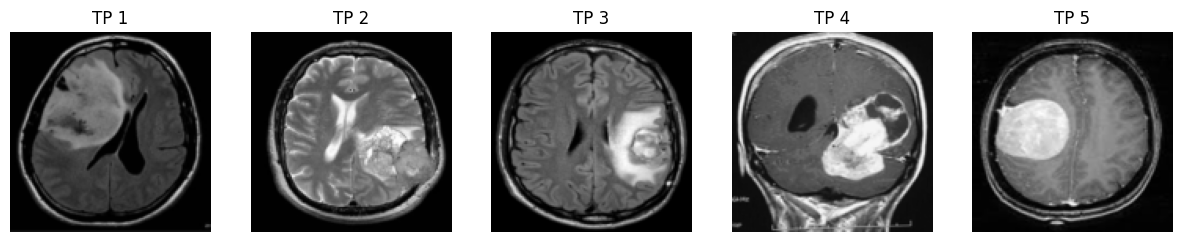


TN Samples:


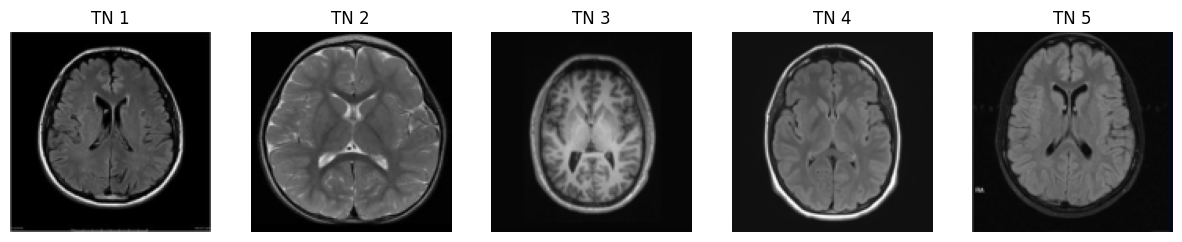


FP Samples:


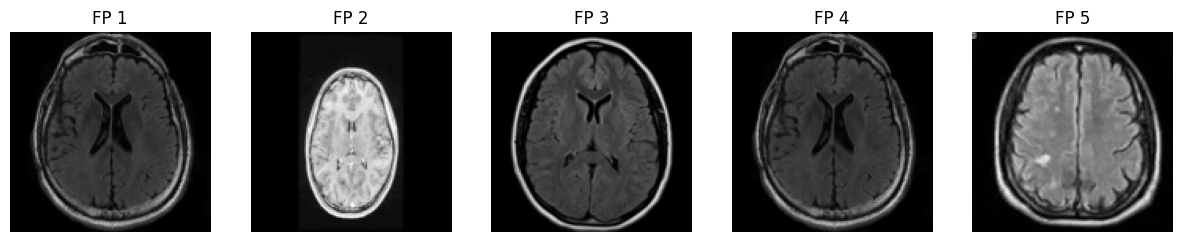


FN Samples:


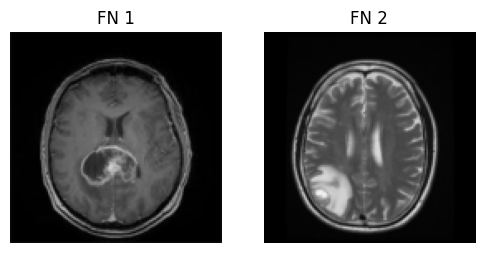

In [15]:
all_model["SVM"] = svm_acc*100
# Plot confusion matrix samples
brain_tumor_svm.plot_confusion_matrix_samples(best_model)

### Convolutional neural network (CNN)

Convolutional Neural Networks (CNNs) are a type of deep learning model primarily used for image recognition and processing tasks. They are designed to mimic the way the human visual cortex processes visual information. CNNs consist of multiple layers, including convolutional layers, pooling layers, and fully connected layers, that work together to learn features and patterns from the input data. Here's a high-level overview of how CNNs work:

1.  Convolutional layers: Convolutional layers are the main building blocks of CNNs. They apply a set of filters (or kernels) to the input image or feature maps, which helps the network learn local features such as edges, textures, and shapes. The convolution operation involves sliding the filters over the input image or feature maps and computing the dot product between the filter and the corresponding local region. This process generates new feature maps that capture the presence of the learned features in the input.

2.  Activation functions: After the convolution operation, an activation function, such as the Rectified Linear Unit (ReLU), is applied to the output feature maps. This introduces non-linearity into the model, enabling the network to learn complex patterns and features from the data.

3.  Pooling layers: Pooling layers are used to reduce the spatial dimensions of the feature maps, which helps to decrease the computational complexity and control overfitting. The most common pooling operation is max-pooling, which selects the maximum value from a local region (e.g., 2x2 or 3x3) in the feature map. Other pooling techniques include average pooling and global average pooling.

4.  Fully connected layers: After a series of convolutional and pooling layers, the resulting feature maps are flattened and fed into one or more fully connected (dense) layers. These layers are responsible for combining the learned features and making the final prediction or classification. The last fully connected layer typically has as many nodes as there are classes in the classification problem and uses a softmax activation function to generate probabilities for each class.

5.  Training: CNNs are trained using backpropagation and gradient descent, similar to other neural networks. The model learns to adjust its filter weights and biases to minimize a loss function, which measures the difference between the predicted outputs and the ground-truth labels. This process usually involves dividing the training data into mini-batches and updating the weights and biases iteratively using a technique called Stochastic Gradient Descent (SGD) or one of its variants (e.g., Adam, RMSprop).

In summary, CNNs work by applying a series of convolutional, activation, pooling, and fully connected layers to learn hierarchical features from input images. These features are then used to make predictions or classifications, and the model is trained using backpropagation and gradient descent to minimize the loss function. CNNs have been highly successful in various computer vision tasks, such as image classification, object detection, and semantic segmentation.

</br>
<br>
</br>
<center>
<img src="https://editor.analyticsvidhya.com/uploads/94787Convolutional-Neural-Network.jpeg"/>
</center>

</br>


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

#### CNN Helper Class

In [17]:
class BrainTumorCNN:
    '''Brain Tumor CNN Classifier
    Args:
        dataset (Dataset): Dataset
        num_epochs (int): Number of epochs
        batch_size (int): Batch size
        learning_rate (float): Learning rate
        device (torch.device): Device to use for training
        loss_history (list): List of loss values
        accuracy_history (list): List of accuracy values
        patience (int): Number of epochs to wait before early stopping
        model (torch.nn.Module): Model
        val_loader (DataLoader): Validation data loader
        model_score (float): Model score'''
    def __init__(self, dataset, patience = 5,num_epochs=150, batch_size=32, learning_rate=1e-3, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        self.dataset = dataset
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.device = device
        self.loss_history = []
        self.accuracy_history = []
        self.patience = patience
        self.model = None
        self.val_loader = None
        self.model_score = 0

    # Create train and validation data loaders
    def create_data_loaders(self, train_indices, val_indices):
        train_set = torch.utils.data.Subset(self.dataset, train_indices)
        val_set = torch.utils.data.Subset(self.dataset, val_indices)

        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=False)
        return train_loader, val_loader
    
    # Train the model for one epoch
    def train(self, model, train_loader, optimizer, criterion):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(self.device)
            labels = labels.to(self.device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / (i + 1)
        epoch_accuracy = 100.0 * correct / total
        return epoch_loss, epoch_accuracy
    
    # Validate the model for one epoch
    def validate(self, model, val_loader, criterion):
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(val_loader):
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / (i + 1)
        epoch_accuracy = 100.0 * correct / total
        return epoch_loss, epoch_accuracy
    
    # Plot the loss and accuracy history for training and validation
    def plot_history(self):
        num_epochs = len(self.loss_history)
        epochs = range(1, num_epochs + 1)
        train_losses, val_losses = zip(*self.loss_history)
        train_accuracies, val_accuracies = zip(*self.accuracy_history)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        ax1.plot(epochs, train_losses, label="Training Loss")
        ax1.plot(epochs, val_losses, label="Validation Loss")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss")
        ax1.legend()
        
        ax2.plot(epochs, train_accuracies, label="Training Accuracy")
        ax2.plot(epochs, val_accuracies, label="Validation Accuracy")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Accuracy")
        ax2.legend()

        plt.show()

    # Plot confusion matrix
    def plot_confusion_matrix(self, model, val_loader):
        model.eval()
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = model(images)
                _, predictions = torch.max(outputs, 1)

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())

        cm = confusion_matrix(all_labels, all_predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

    # Train the model, early stopping is used to prevent overfitting
    def run(self, train_indices, val_indices):
        train_loader, val_loader = self.create_data_loaders(train_indices, val_indices)

        model = self.create_model().to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

        best_val_accuracy = 0
        patience_counter = 0

        for epoch in range(self.num_epochs):
            train_loss, train_accuracy = self.train(model, train_loader, optimizer, criterion)
            val_loss, val_accuracy = self.validate(model, val_loader, criterion)

            self.loss_history.append((train_loss, val_loss))
            self.accuracy_history.append((train_accuracy, val_accuracy))

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.patience:
                print(f"Train accuracy: {train_accuracy:.2f}%")
                print(f"Test accuracy: {val_accuracy:.2f}%")
                print(f"Early stopping at epoch {epoch + 1}.")
                break
        
        self.model = model
        self.val_loader = val_loader
        self.plot_history()
        self.plot_confusion_matrix(model, val_loader)
        self.model_score = val_accuracy
        

    # Plot confusion matrix for samples
    def plot_confusion_matrix_samples(self, train_indices, val_indices):
        model = self.model
        val_loader = self.val_loader
        dataset = self.dataset
        # Get predictions and true labels for the validation set
        y_true, y_pred = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = model(images)
                _, predicted = outputs.max(1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        # Separate the indices of true positive, true negative, false positive, and false negative cases
        tp_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t == p == 1]
        tn_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t == p == 0]
        fp_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t == 0 and p == 1]
        fn_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t == 1 and p == 0]

        print(f"True Positive: {len(tp_indices)}")
        print(f"True Negative: {len(tn_indices)}")
        print(f"False Positive: {len(fp_indices)}")
        print(f"False Negative: {len(fn_indices)}")

        # Plot sample images for each case in the confusion matrix
        self.plot_sample_images(dataset, tp_indices, "True Positive")
        self.plot_sample_images(dataset, tn_indices, "True Negative")
        self.plot_sample_images(dataset, fp_indices, "False Positive")
        self.plot_sample_images(dataset, fn_indices, "False Negative")

    # Plot sample images
    def plot_sample_images(self, dataset, indices, title, n_samples=9):
        indices = random.sample(indices, min(n_samples, len(indices)))

        fig, axes = plt.subplots(3, 3, figsize=(9, 9))
        for i, idx in enumerate(indices):
            image, label = dataset[idx]
            ax = axes[i // 3, i % 3]
            ax.imshow(image.permute(1, 2, 0).numpy())
            ax.set_title(f"Index: {idx}, Label: {label}")
            ax.axis('off')

        plt.suptitle(title)
        plt.show()
 

#### Custom CNN Architecture

In [18]:
# Create a custom CNN model
class CustomCNN(nn.Module):
    """Custom CNN model for the classification task."""
    def __init__(self):
        super().__init__()
        # Define the first sequence of layers (Conv2D -> MaxPool2D -> Conv2D -> MaxPool2D)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=2),
            nn.MaxPool2d(2, 2))
        # Define four additional Conv2D layers
        self.conv1 = nn.Conv2d(128, 64, kernel_size=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        # Define a MaxPool2D layer
        self.maxpool = nn.MaxPool2d(2, 2)
        # Define a Flatten layer to flatten the tensor
        self.flat = nn.Flatten(1)
        # Define a Linear layer for the final output
        self.linear = nn.Linear(7200, 2)

    # Define the forward pass for the model
    def forward(self, x):
        # Pass input through the first sequence of layers
        x = F.relu(self.layer1(x))
        
        # Pass input through a skip connection (conv1 -> conv2)
        x = self.conv1(x) + self.conv2(self.conv1(x))
        x = F.relu(x)
        
        # Pass input through another skip connection (conv3 -> conv4)
        x = self.conv3(x) + self.conv4(self.conv3(x))
        
        # Pass input through the MaxPool2D layer
        x = F.relu(self.maxpool(x))
        
        # Flatten the tensor
        x = self.flat(x)
        
        # Pass the flattened tensor through the Linear layer
        x = self.linear(x)
        
        return x

In [19]:
model = CustomCNN().to('cuda' if torch.cuda.is_available() else 'cpu')
summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─MaxPool2d: 2-2                    --
|    └─Conv2d: 2-3                       32,896
|    └─MaxPool2d: 2-4                    --
├─Conv2d: 1-2                            8,256
├─Conv2d: 1-3                            36,928
├─Conv2d: 1-4                            2,080
├─Conv2d: 1-5                            9,248
├─MaxPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            14,402
Total params: 105,602
Trainable params: 105,602
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─MaxPool2d: 2-2                    --
|    └─Conv2d: 2-3                       32,896
|    └─MaxPool2d: 2-4                    --
├─Conv2d: 1-2                            8,256
├─Conv2d: 1-3                            36,928
├─Conv2d: 1-4                            2,080
├─Conv2d: 1-5                            9,248
├─MaxPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            14,402
Total params: 105,602
Trainable params: 105,602
Non-trainable params: 0

In [20]:
class BrainTumorCustomCNN(BrainTumorCNN):
    def create_model(self):
        model = CustomCNN()
        return model

In [21]:
# Initialize BrainTumorCustomCNN with the dataset
brain_tumor_custom_cnn = BrainTumorCustomCNN(dataset)



In [22]:
# Split the dataset into training and validation sets
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

#### Manual Hyperparameter Tuning - 1 for custom CNN

-   Tuning learning_rate, to check the performance
-   Performance metric Test accuracy

Train accuracy: 59.90%
Test accuracy: 66.67%
Early stopping at epoch 8.


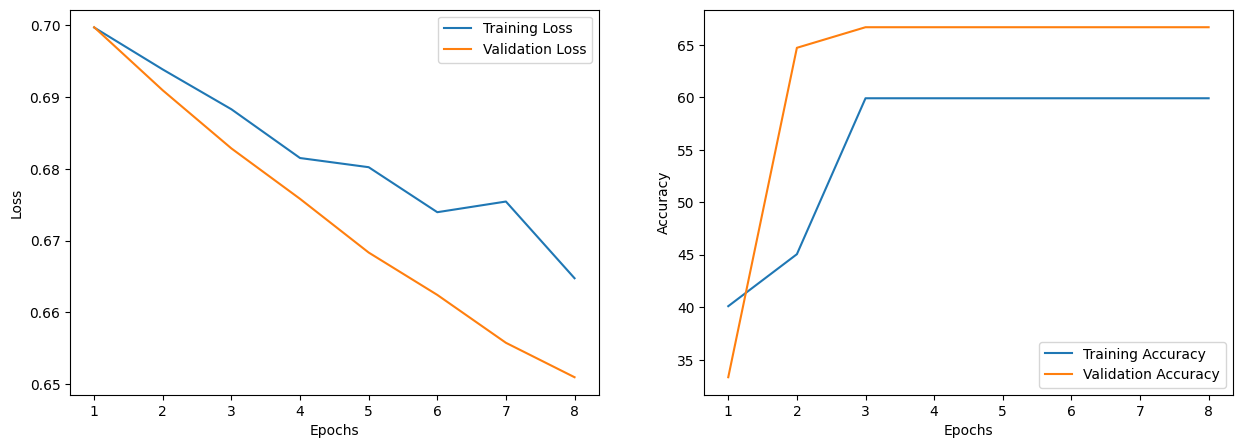

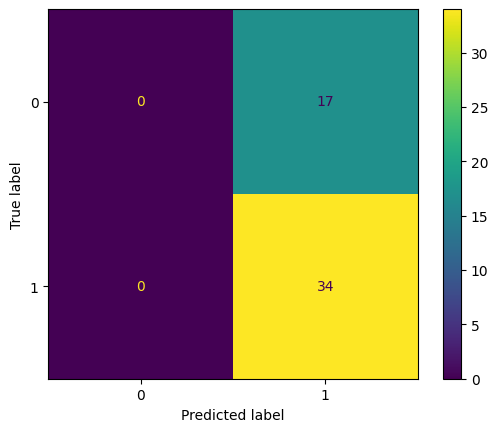

In [23]:
# Create an instance of the BrainTumorCustomCNN class with your desired hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 1e-5 
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

brain_tumor_custom_cnn_1 = BrainTumorCustomCNN(dataset,patience,num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, device=device)

# Run training, validation, and plot the results
brain_tumor_custom_cnn_1.run(train_indices, val_indices)

name = 'Custom_CNN'+ '_lr' + str(learning_rate)
all_model[name] = brain_tumor_custom_cnn_1.model_score

#### Manual Hyperparameter Tuning - 2 for custom CNN

-   Tuning learning_rate, to check the performance
-   Performance metric Test accuracy

Train accuracy: 75.25%
Test accuracy: 76.47%
Early stopping at epoch 13.


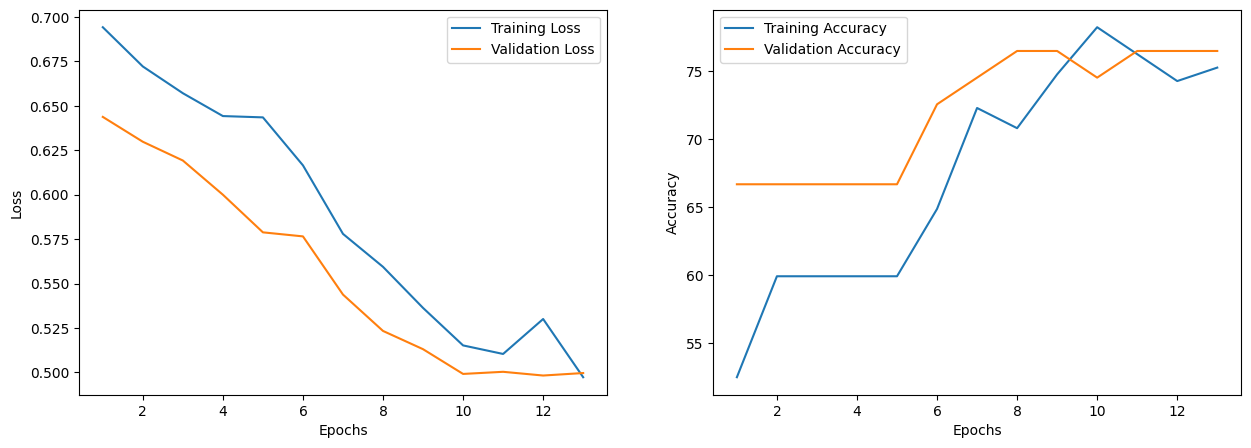

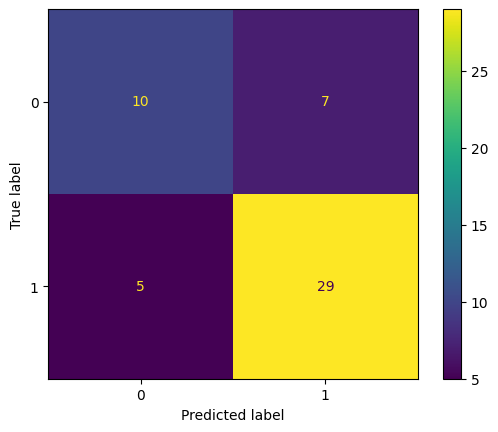

In [24]:
# Create an instance of the BrainTumorCustomCNN class with your desired hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 1e-4
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

brain_tumor_custom_cnn_2 = BrainTumorCustomCNN(dataset,patience,num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, device=device)

# Run training, validation, and plot the results
brain_tumor_custom_cnn_2.run(train_indices, val_indices)

name = 'Custom_CNN'+ '_lr' + str(learning_rate)
all_model[name] = brain_tumor_custom_cnn_2.model_score

#### Manual Hyperparameter Tuning - 3 for custom CNN

-   Tuning learning_rate and patience, to check the performance
-   Performance metric Test accuracy

Train accuracy: 89.11%
Test accuracy: 80.39%
Early stopping at epoch 13.


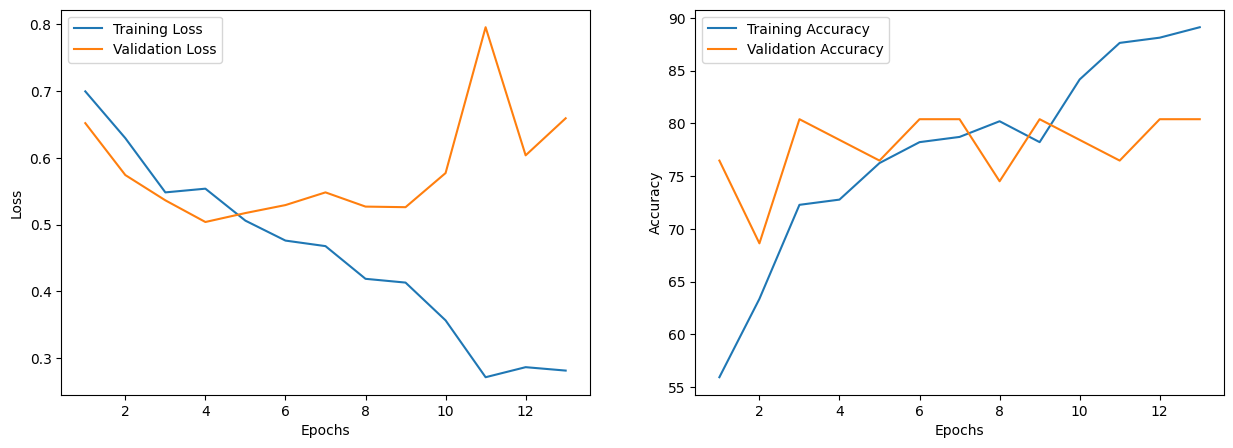

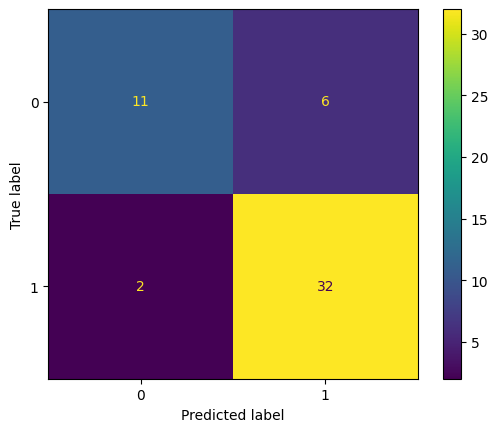

In [25]:
# Create an instance of the BrainTumorCustomCNN class with your desired hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 1e-3
patience = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

brain_tumor_custom_cnn_3 = BrainTumorCustomCNN(dataset,patience,num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, device=device)

# Run training, validation, and plot the results
brain_tumor_custom_cnn_3.run(train_indices, val_indices)

name = 'Custom_CNN'+ '_lr' + str(learning_rate)
all_model[name] = brain_tumor_custom_cnn_3.model_score

True Positive: 32
True Negative: 11
False Positive: 6
False Negative: 2


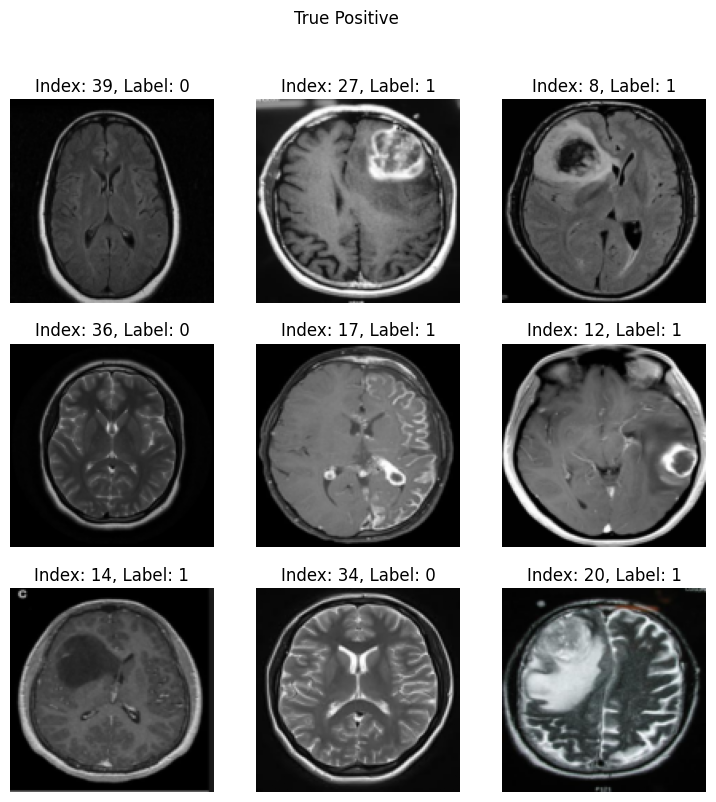

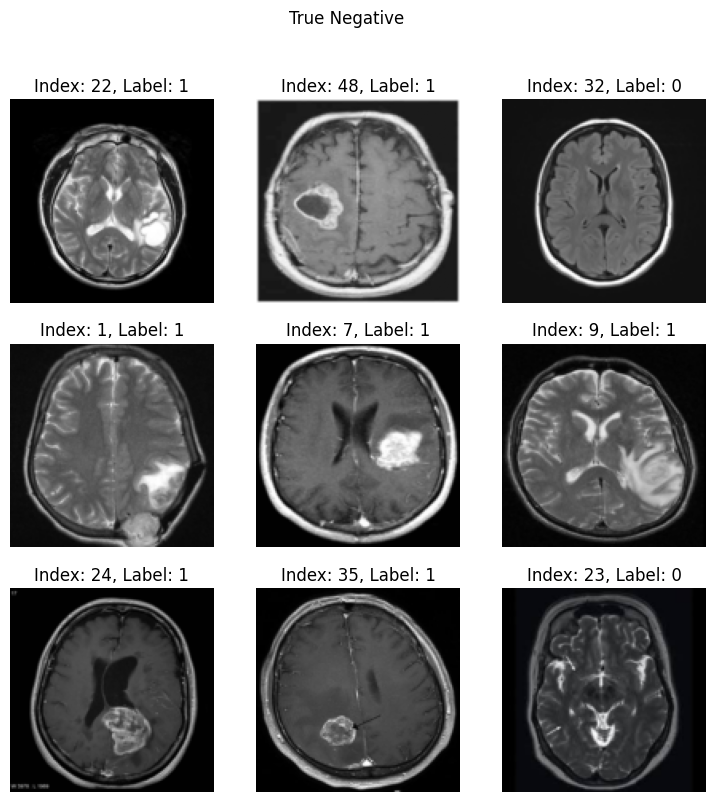

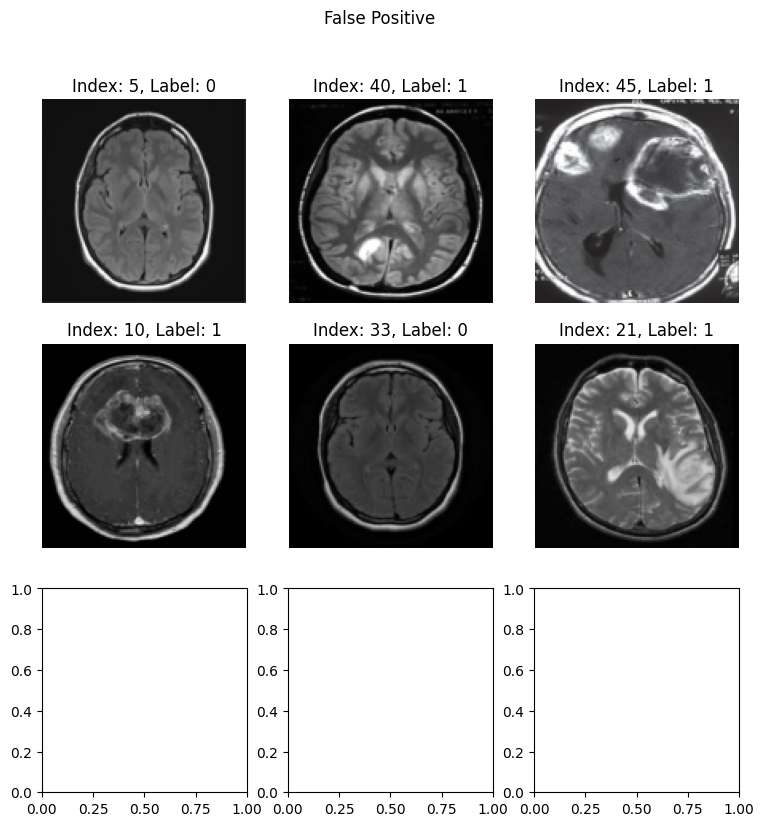

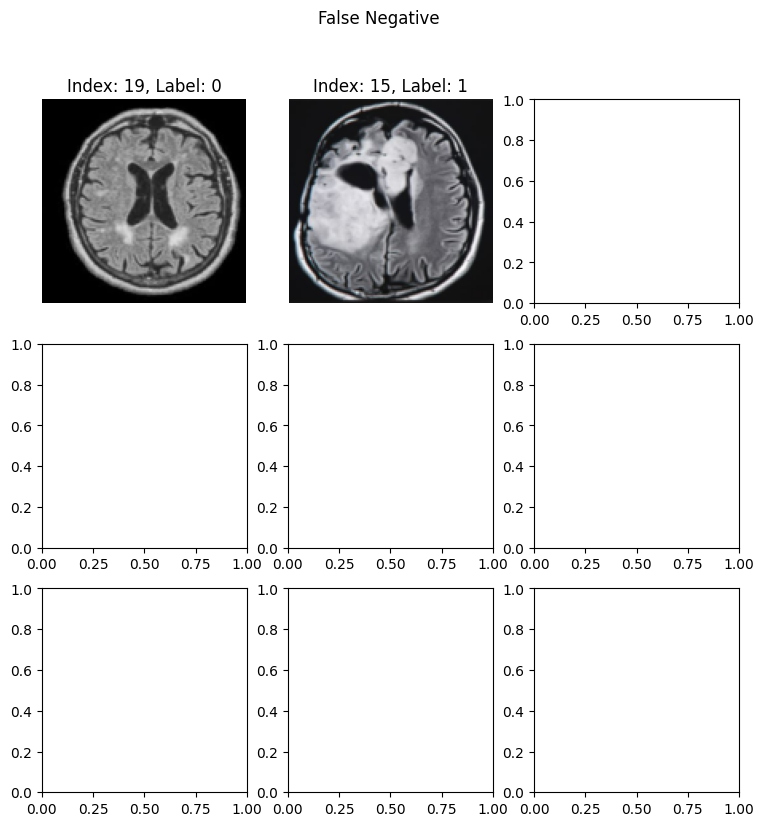

In [26]:

brain_tumor_custom_cnn_3.plot_confusion_matrix_samples(train_indices, val_indices)

#### Plotting Custom CNN Accuracy

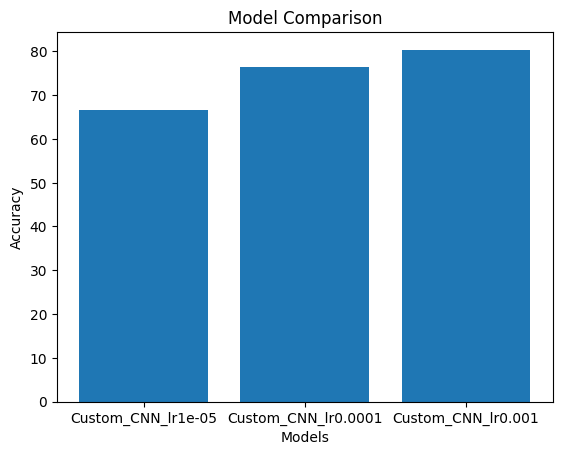

In [27]:
custom_cnn = all_model.copy()
# Drop a key from the dictionary
custom_cnn.pop('SVM')

# Extract keys and values from the dictionary
keys = list(custom_cnn.keys())
values = list(custom_cnn.values())

# Create the bar plot
plt.bar(keys, values)

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Comparison")

# Display the plot
plt.show()


### resnet18

ResNet-18 is a variant of the ResNet (Residual Network) architecture, which is a popular deep learning model for image classification tasks. The "18" in ResNet-18 denotes the total number of layers in the network, which consists of 18 layers, including convolutional and fully connected layers.

ResNet was introduced by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in their paper "Deep Residual Learning for Image Recognition" in 2015. The main innovation in ResNet is the introduction of residual connections (also known as skip connections) that allow the network to learn the identity function more efficiently. These connections allow the gradients to bypass some layers during backpropagation, which helps mitigate the vanishing gradient problem and enables training of deeper networks.

The architecture of ResNet-18 consists of:

1.  An initial convolutional layer with 64 filters, 7x7 kernel size, and stride 2.
2.  A max-pooling layer with 3x3 kernel size and stride 2.
3.  Four sets of residual blocks, where each set contains two residual blocks. Each residual block has two convolutional layers with 3x3 kernel size.
    -   In the first set, the number of filters is 64.
    -   In the second set, the number of filters is doubled to 128, and the input is downsampled using a stride of 2 in the first layer.
    -   In the third set, the number of filters is doubled again to 256, and the input is downsampled using a stride of 2 in the first layer.
    -   In the fourth set, the number of filters is doubled once more to 512, and the input is downsampled using a stride of 2 in the first layer.
4.  An average pooling layer with kernel size equal to the spatial dimensions of the input.
5.  A fully connected layer with an output size equal to the number of classes in the classification task.
6.  A softmax activation function to obtain probabilities for each class.
   
ResNet-18 has fewer layers compared to other variants like ResNet-34, ResNet-50, ResNet-101, and ResNet-152. As a result, ResNet-18 is less computationally expensive and can be trained more quickly, but it may achieve slightly lower accuracy on some tasks compared to deeper ResNet models.

</br>
<br>
</br>
<center>
<img src="https://www.researchgate.net/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png"/>
</center>

</br>

In [28]:
class BrainTumorResnetCNN(BrainTumorCNN):
    def create_model(self):
        model = models.resnet18(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 2)
        return model

#### Manual Hyperparameter Tuning - 1 for resnet18

-   Tuning learning_rate, to check the performance
-   Performance metric Test accuracy

/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train accuracy: 100.00%
Test accuracy: 90.20%
Early stopping at epoch 20.


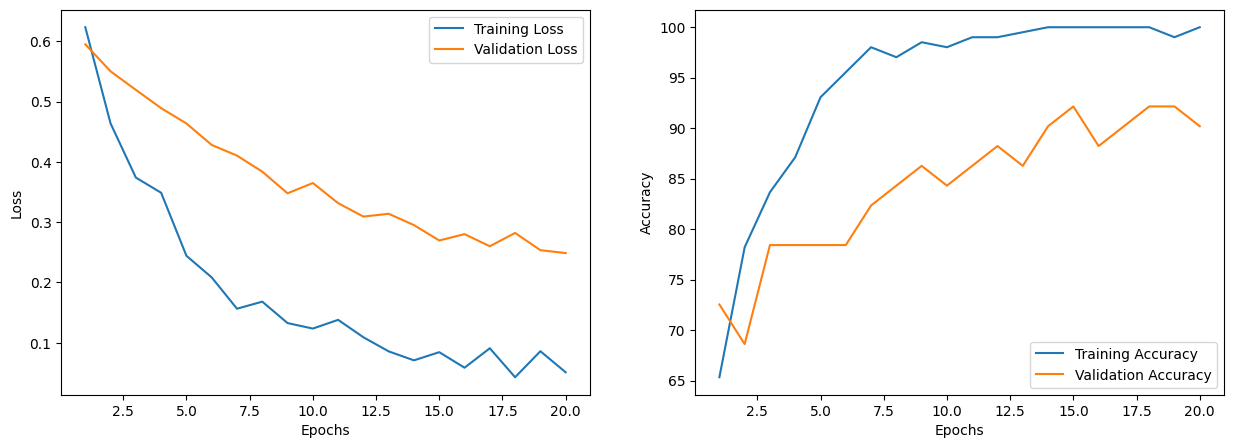

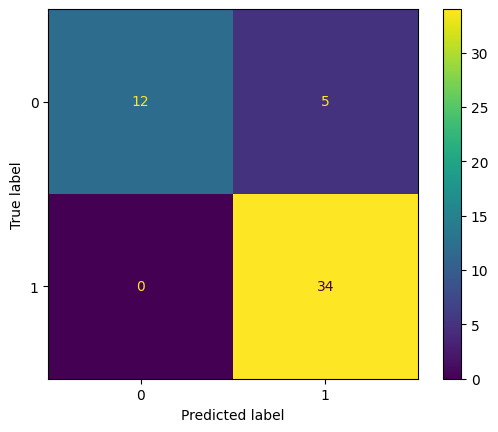

In [29]:
# Create an instance of the BrainTumorCustomCNN class with your desired hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 1e-5
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

brain_tumor_custom_cnn_resnet_1 = BrainTumorResnetCNN(dataset,patience,num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, device=device)

# Run training, validation, and plot the results
brain_tumor_custom_cnn_resnet_1.run(train_indices, val_indices)

name = 'Resnet18'+ '_lr' + str(learning_rate)
all_model[name] = brain_tumor_custom_cnn_resnet_1.model_score

#### Manual Hyperparameter Tuning - 2 for resnet18

-   Tuning learning_rate and patience, to check the performance
-   Performance metric Test accuracy

/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train accuracy: 92.08%
Test accuracy: 78.43%
Early stopping at epoch 18.


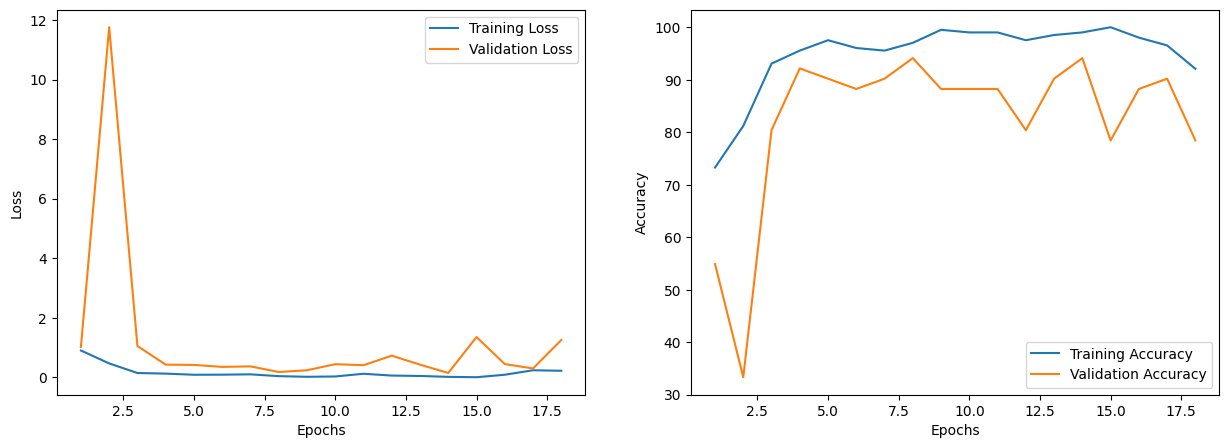

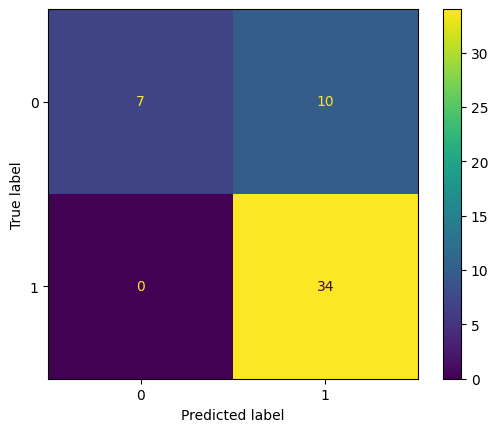

In [30]:
# Create an instance of the BrainTumorCustomCNN class with your desired hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 1e-3
patience = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

brain_tumor_custom_cnn_resnet_2 = BrainTumorResnetCNN(dataset,patience,num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, device=device)

# Run training, validation, and plot the results
brain_tumor_custom_cnn_resnet_2.run(train_indices, val_indices)

name = 'Resnet18'+ '_lr' + str(learning_rate)
all_model[name] = brain_tumor_custom_cnn_resnet_2.model_score

#### Manual Hyperparameter Tuning - 3 for resnet18

-   Tuning num_epochs and patience, to check the performance
-   Performance metric Test accuracy

/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train accuracy: 99.50%
Test accuracy: 92.16%
Early stopping at epoch 19.


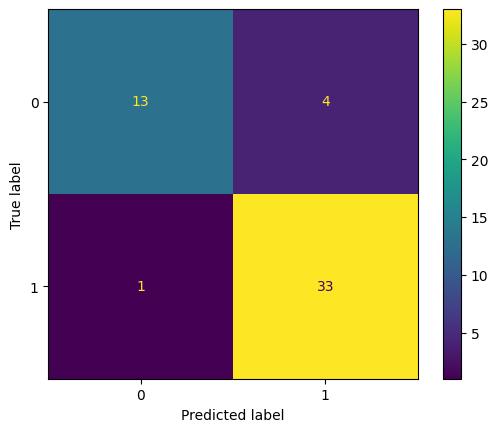

In [32]:
# Create an instance of the BrainTumorCustomCNN class with your desired hyperparameters
num_epochs = 100
batch_size = 32
learning_rate = 1e-3
patience = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

brain_tumor_custom_cnn_resnet_3 = BrainTumorResnetCNN(dataset,patience,num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, device=device)

# Run training, validation, and plot the results
brain_tumor_custom_cnn_resnet_3.run(train_indices, val_indices)



True Positive: 33
True Negative: 13
False Positive: 4
False Negative: 1


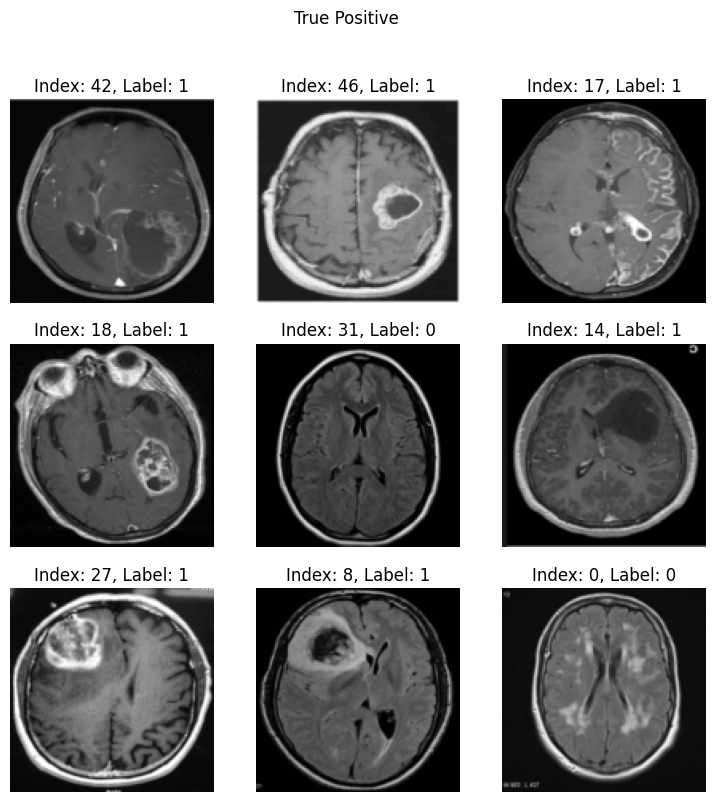

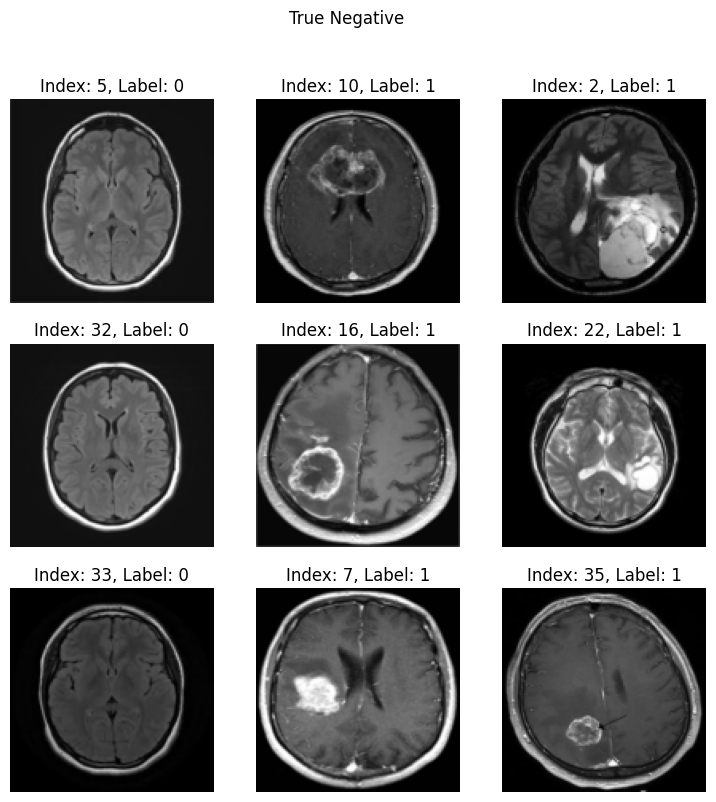

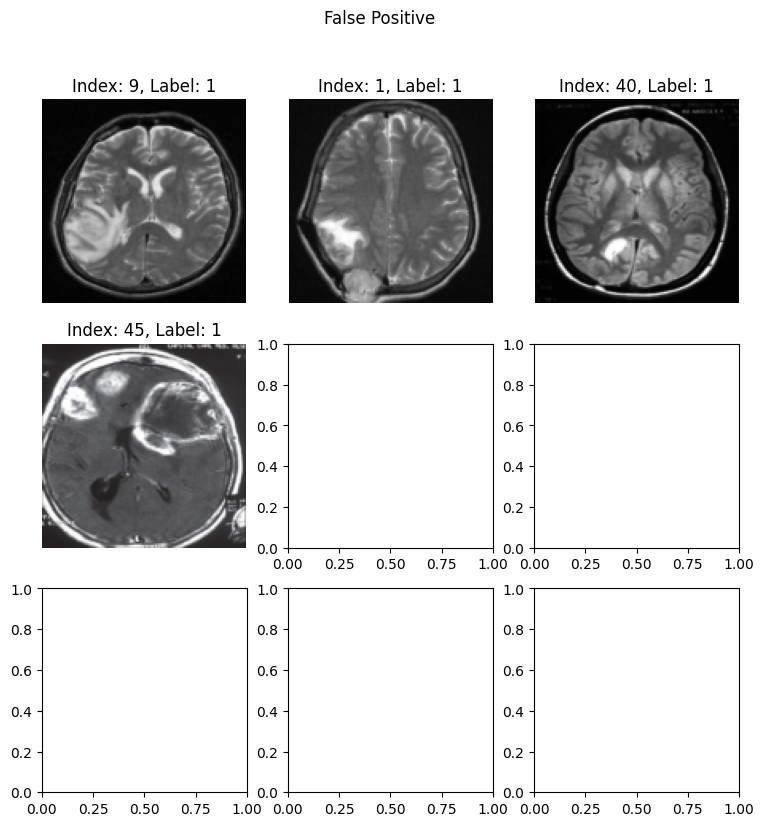

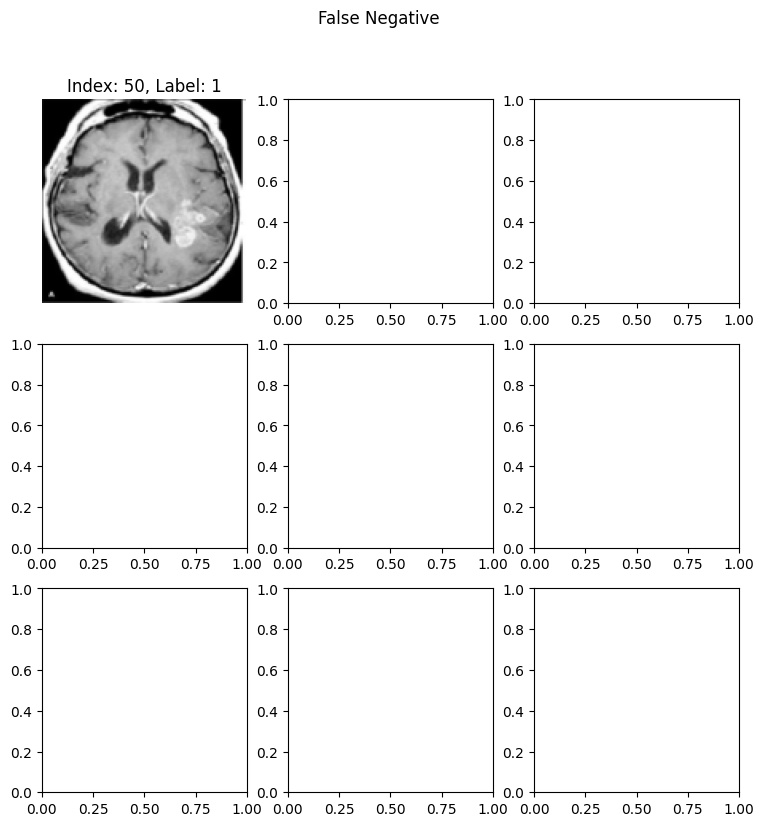

In [38]:
brain_tumor_custom_cnn_resnet_3.plot_confusion_matrix_samples(train_indices, val_indices)

In [36]:
name = 'Resnet18'+ '_lr' + str(learning_rate)+'_epochs'+str(num_epochs)
all_model[name] = brain_tumor_custom_cnn_resnet_3.model_score

#### Plotting Accuracy for Resnet8

In [37]:
all_model

{'SVM': 73.58490566037736,
 'Custom_CNN_lr1e-05': 66.66666666666667,
 'Custom_CNN_lr0.0001': 76.47058823529412,
 'Custom_CNN_lr0.001': 80.3921568627451,
 'Resnet18_lr1e-05': 90.19607843137256,
 'Resnet18_lr0.001': 92.15686274509804,
 'Resnet18_lr0.001_epochs100': 92.15686274509804}

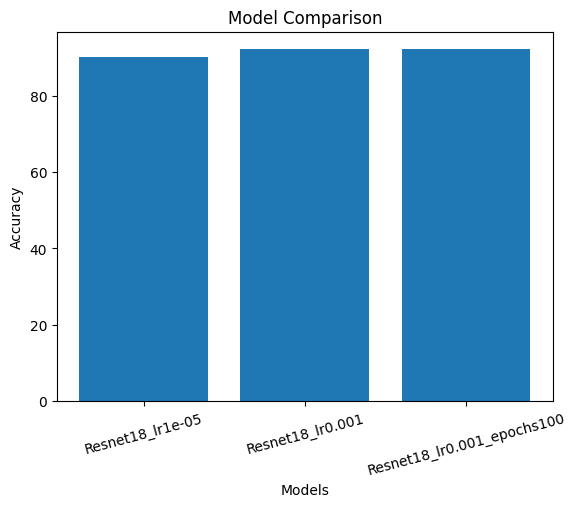

In [43]:

resnet18 = {k: v for k, v in all_model.items() if k.startswith('Resnet18')}

# Extract keys and values from the dictionary
keys = list(resnet18.keys())
values = list(resnet18.values())

# Create the bar plot
plt.bar(keys, values)
plt.xticks(rotation=15)

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Comparison")

# Display the plot
plt.show()


### VGG19

VGG19 is a deep convolutional neural network architecture introduced by Karen Simonyan and Andrew Zisserman in their 2014 paper, "Very Deep Convolutional Networks for Large-Scale Image Recognition." The architecture consists of 19 weight layers, including 16 convolutional layers and 3 fully connected layers, hence the name VGG19.

The VGG19 architecture can be summarized as follows:

1.  Input layer: Takes an input image of size 224x224x3 (height x width x channels).
2.  Convolutional layers: There are 16 convolutional layers with 3x3 filters and a stride of 1. The number of filters starts at 64 and increases by a factor of 2 after every max-pooling layer, reaching a maximum of 512 filters. Padding is used to preserve spatial dimensions.
3.  Activation functions: After each convolutional layer, a Rectified Linear Unit (ReLU) activation function is applied to introduce non-linearity into the model.
4.  Max-pooling layers: After some of the convolutional layers, 2x2 max-pooling layers with a stride of 2 are used to reduce the spatial dimensions and increase the receptive field.
5.  Fully connected layers: After the final max-pooling layer, the feature maps are flattened, and three fully connected layers are applied. The first two have 4096 neurons each, and the final layer has as many neurons as there are classes in the classification task. In the original VGG19, this was set to 1000 for the ImageNet dataset.
6.  Softmax layer: A softmax activation function is applied to the output of the final fully connected layer to produce class probabilities.
7.  Loss function: A cross-entropy loss function is used to train the model by minimizing the difference between the predicted probabilities and the ground-truth labels.
The VGG19 architecture is known for its simplicity and depth, which enables it to achieve high accuracy in various image classification tasks. However, it is also computationally expensive and has a large number of parameters, making it more challenging to train and deploy on resource-constrained devices.

</br>
<br>
</br>
<center>
<img src="https://www.researchgate.net/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg"/>
</center>

</br>


In [44]:
class BrainTumorVGGCNN(BrainTumorCNN):
    def create_model(self):
        model = models.vgg19(pretrained=True)
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, 2)
        return model

#### Manual Hyperparameter Tuning - 1 for VGG19

-   Tuning learning_rate and patience, to check the performance
-   Performance metric Test accuracy

/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train accuracy: 54.46%
Test accuracy: 66.67%
Early stopping at epoch 6.


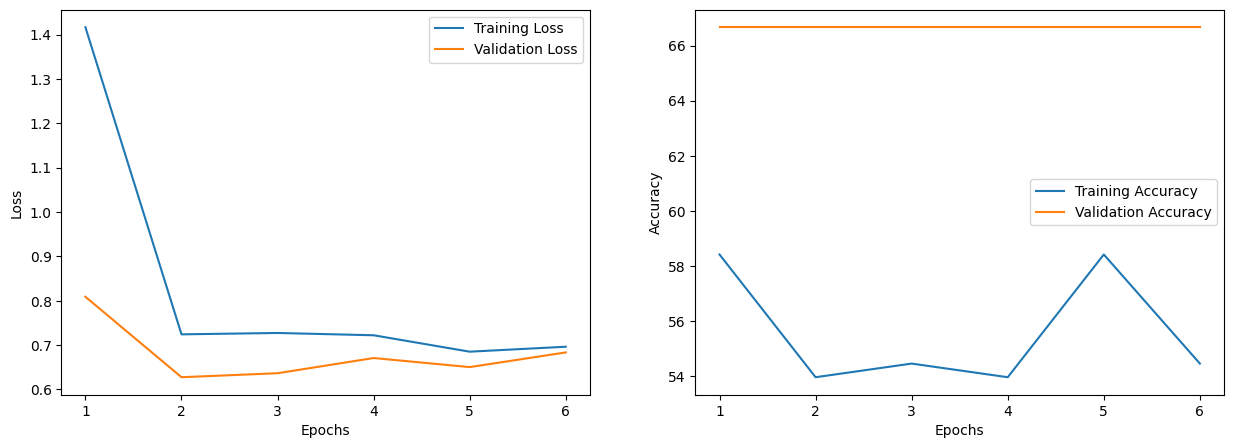

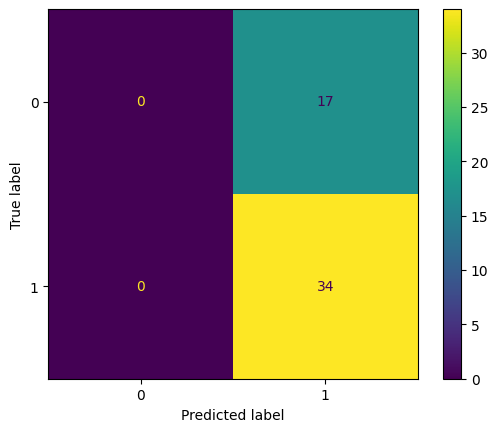

In [45]:
# Create an instance of the BrainTumorCustomCNN class with your desired hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 1e-3
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

brain_tumor_custom_cnn_vgg_1 = BrainTumorVGGCNN(dataset,patience,num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, device=device)

# Run training, validation, and plot the results
brain_tumor_custom_cnn_vgg_1.run(train_indices, val_indices)

name = 'VGG19'+ '_lr' + str(learning_rate)
all_model[name] = brain_tumor_custom_cnn_vgg_1.model_score

#### Manual Hyperparameter Tuning - 2 for VGG19

-   Tuning learning_rate and patience, to check the performance
-   Performance metric Test accuracy

In [46]:
# Create an instance of the BrainTumorCustomCNN class with your desired hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 1e-6
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

brain_tumor_custom_cnn_vgg_2 = BrainTumorVGGCNN(dataset,patience,num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, device=device)

# Run training, validation, and plot the results
brain_tumor_custom_cnn_vgg_2.run(train_indices, val_indices)

name = 'VGG19'+ '_lr' + str(learning_rate)
all_model[name] = brain_tumor_custom_cnn_vgg_2.model_score

/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train accuracy: 79.70%
Test accuracy: 84.31%
Early stopping at epoch 23.


#### Manual Hyperparameter Tuning - 3 for VGG19

-   Tuning learning_rate and patience, to check the performance
-   Performance metric Test accuracy

In [47]:
# Create an instance of the BrainTumorCustomCNN class with your desired hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 1e-5
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

brain_tumor_custom_cnn_vgg_3 = BrainTumorVGGCNN(dataset,patience,num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, device=device)

# Run training, validation, and plot the results
brain_tumor_custom_cnn_vgg_3.run(train_indices, val_indices)

name = 'VGG19'+ '_lr' + str(learning_rate)
all_model[name] = brain_tumor_custom_cnn_vgg_3.model_score

/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/meghanshubhatt/miniconda3/envs/mymachinelearning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train accuracy: 100.00%
Test accuracy: 94.12%
Early stopping at epoch 17.


True Positive: 33
True Negative: 15
False Positive: 2
False Negative: 1


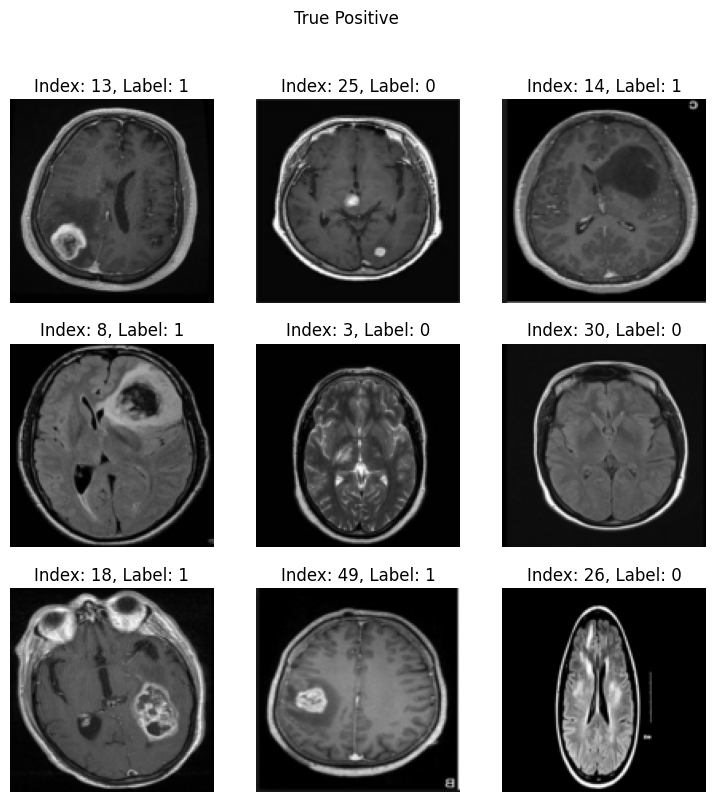

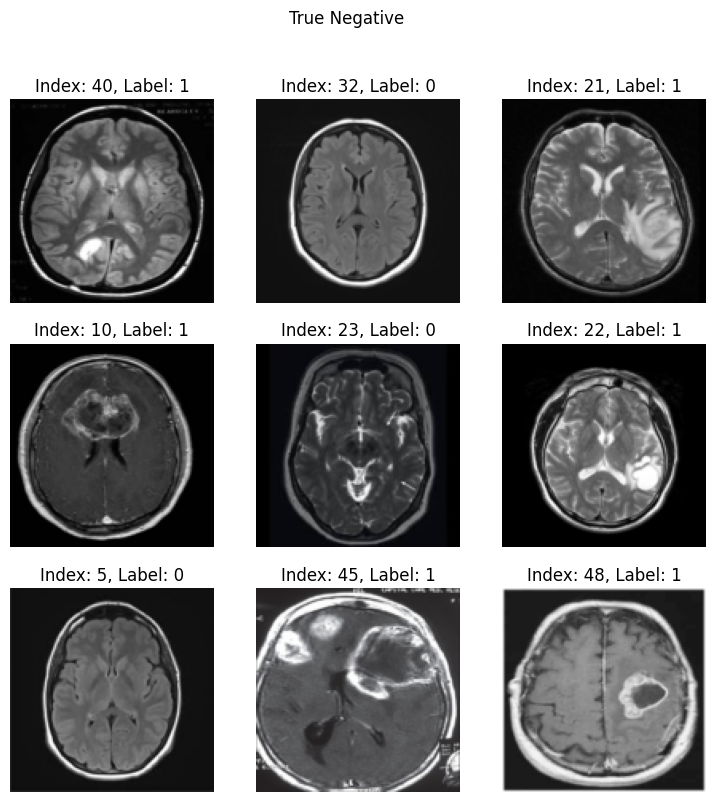

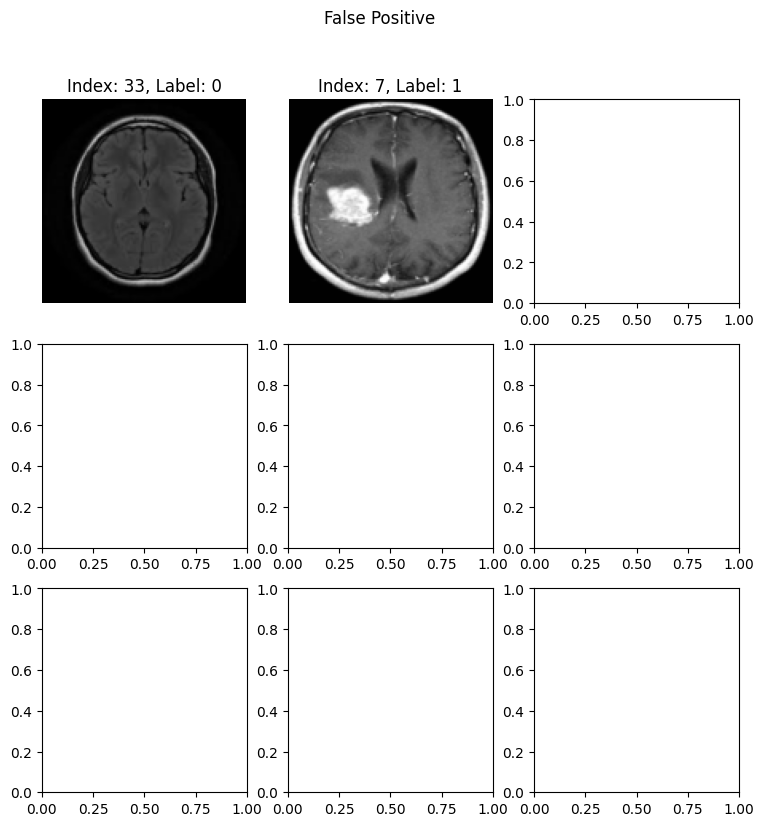

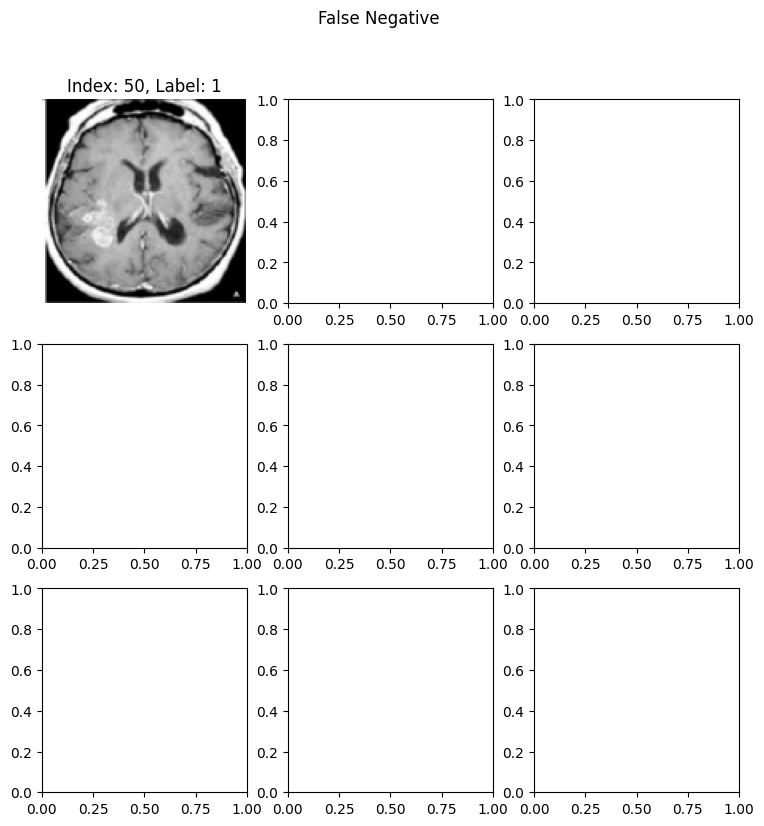

In [48]:
brain_tumor_custom_cnn_vgg_3.plot_confusion_matrix_samples(train_indices, val_indices)

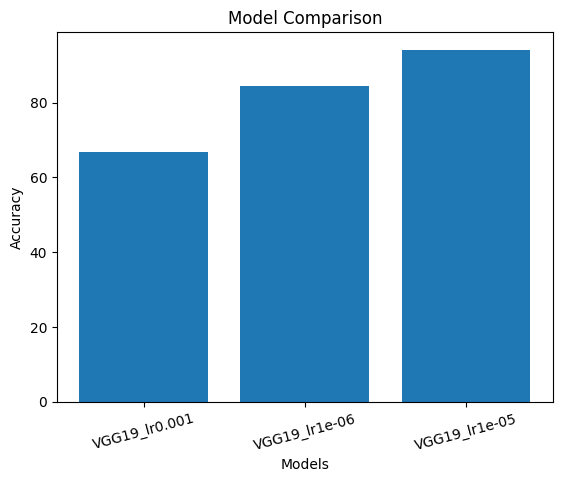

In [49]:
# key starts with Resnet18
vgg19 = {k: v for k, v in all_model.items() if k.startswith('VGG19')}

# Extract keys and values from the dictionary
keys = list(vgg19.keys())
values = list(vgg19.values())

# Create the bar plot
plt.bar(keys, values)
plt.xticks(rotation=15)

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Comparison")

# Display the plot
plt.show()


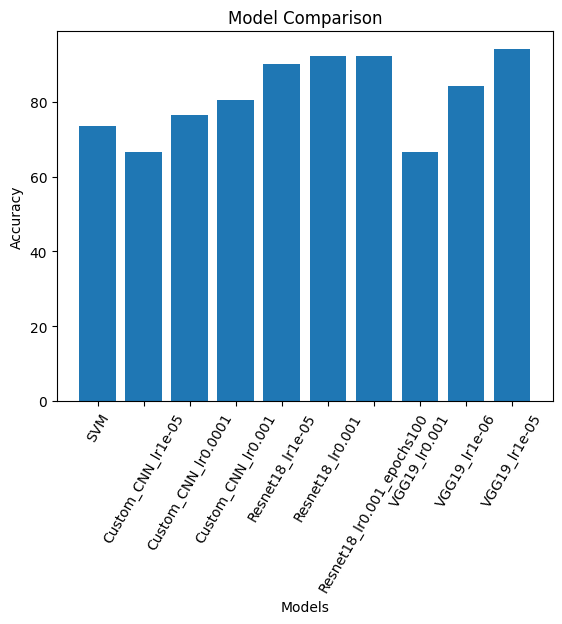

In [53]:

# Extract keys and values from the dictionary
keys = list(all_model.keys())
values = list(all_model.values())

# Create the bar plot
plt.bar(keys, values)

# Rotate x-axis labels by x degrees
x = 60
plt.xticks(rotation=x)

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Comparison")

# Display the plot
plt.show()


In [54]:
all_model

{'SVM': 73.58490566037736,
 'Custom_CNN_lr1e-05': 66.66666666666667,
 'Custom_CNN_lr0.0001': 76.47058823529412,
 'Custom_CNN_lr0.001': 80.3921568627451,
 'Resnet18_lr1e-05': 90.19607843137256,
 'Resnet18_lr0.001': 92.15686274509804,
 'Resnet18_lr0.001_epochs100': 92.15686274509804,
 'VGG19_lr0.001': 66.66666666666667,
 'VGG19_lr1e-06': 84.31372549019608,
 'VGG19_lr1e-05': 94.11764705882354}

### Summary

In this project, we have explored various machine learning and deep learning models to classify brain tumors. The performance of each model is measured using accuracy. The results for each model are as follows:

    SVM: Achieved an accuracy of 73.58%.
    Custom CNN with a learning rate of 1e-05: Obtained an accuracy of 66.67%.
    Custom CNN with a learning rate of 0.0001: Achieved an accuracy of 76.47%.
    Custom CNN with a learning rate of 0.001: Reached an accuracy of 80.39%.
    ResNet18 with a learning rate of 1e-05: Obtained an accuracy of 90.20%.
    ResNet18 with a learning rate of 0.001: Achieved an accuracy of 92.16%.
    ResNet18 with a learning rate of 0.001 and trained for 100 epochs: Reached an accuracy of 92.16% (same as with the default number of epochs).
    VGG19 with a learning rate of 0.001: Obtained an accuracy of 66.67%.
    VGG19 with a learning rate of 1e-06: Achieved an accuracy of 84.31%.
    VGG19 with a learning rate of 1e-05: Reached the highest accuracy of 94.12%.

In summary, the best-performing model was the VGG19 pre-trained model with a learning rate of 1e-05, which achieved an accuracy of 94.12%. The ResNet18 pre-trained model also showed high performance with different learning rates. Custom CNN models and the SVM classifier provided lower accuracy in comparison to the pre-trained models. These results highlight the effectiveness of transfer learning with pre-trained deep learning models for the brain tumor classification task. Additionally, the choice of learning rate and the number of training epochs can significantly impact the performance of the models.